<img src = 'https://drive.google.com/uc?id=1cPtoRUIVZ2jWaiIl8z1fm4R4V3kwQfZh
' width="170" height="190" align = "left">

# <font color = "green" > <b>Obiective</b></font>

---

Prin parcurgerea acestui capitol veți învăța:

- ce înseamnă clusterizare (gruparea datelor în clustere)
- când folosim tehnici de clusterizare
- cum realizăm clusterizarea (algoritmi de clusterizare)
- care sunt elementele cheie care duc la performanțe mai bune în algoritmii de clusterizare


|                                                                                                                        |
| ---------------------------------------------------------------------------------------------------------------------- |
| <img src='https://drive.google.com/uc?id=1HV8Tdtn20fD2wdlz1hXrFRvgyQ-ZATIv' width="550" ><figcaption align = "center"> |


#Introducere
Structura acestui capitol este următoarea:

- o vederea de ansamblu asupra învățării nesupervizate
- tehnici de clusterizare
- **_k-means_**, algoritm de partiționare a datelor în clustere

La finalul acestui capitol, elevii ar trebui sa înțeleagă algoritmul de clusterizare prezentat și să conștientizeze potențialul clusterizării în cadrul învățarii nesupervizate.

Începem prin a ne pune întrebarea care este obiectivul grupării în clustere (grupuri/ mulțimi).

Clusterizarea aparține metodelor de învățare nesupervizate, învățare în care avem acces la un set de observații (de exemplu, imagini, text) fără informații suplimentare. Scopul învățării nesupervizate este de a descoperi structura datelor. De exemplu, in cazul modelelor de generate (care aparțin categoriei de învățăre nesupervizata), algoritmul trebuie să producă noi seturi de date similare cu cele observate. Mai precis, dacă datele provin dintr-un un set de imagini, se cere generarea unor imagini noi, care să fie similare celor date initial.

Clusterizarea, pe de altă parte, se concentrează pe găsirea modului în care datele pot fi grupate pe baza structurii și a asemănărilor dintre ele.


##Instalare packages


In [1]:
# Instalare packages
# ! pip install ipyplot


## Bibliotecile **_numpy_** și **_matplotlib_**


In [4]:
# Import-uri
%matplotlib inline

# We import numpy, which is a scientific library for python.
import numpy as np
import math

# We also import matplotlib, which is a useful plotting library for python.
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import IPython
from IPython.display import display
import imageio
import base64
import ipyplot
import ipywidgets as widgets

#
import sklearn.datasets as dataset

import glob
import random

from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings

warnings.filterwarnings("ignore")

##Definirea funcțiilor utile


In [17]:
# Funcții utile
def generate_data(n_samples=20, n_feats=2):
    """Generates simulated data.

    Args:
        n_samples (int): observed students.
        n_feats (int): number of features characterizing each student.
        n_groups (int): number of groups (clusters).

    Returns:
        x (ndarray): the features (inputs).
    """
    # We fix the seed to our random number generator to ensure that
    # we always get the same psuedo-random number sequence.
    np.random.seed(121)

    # Sample features for n_samples students, distributed
    # around n_groups centers.
    x, _ = dataset.make_blobs(
        n_samples=n_samples - 2,
        n_features=n_feats,
        centers=[[9, 21], [9, 12], [20, 15], [20, 8]],
        cluster_std=[[2, 1], [1, 1], [2, 1], [2, 1]],
        center_box=(5, 25),
    )
    # add two extra students to better emphasize our findings
    x = np.append(x, [[1, 5], [15, 1]], axis=0)
    return x


def generate_nonconvex_data(n_samples=20, n_feats=2):
    """Generates simulated data for a non-convex distribution of points.

    Args:
        n_samples (int): observed students.
        n_feats (int): number of features characterizing each student.
        n_groups (int): number of groups (clusters).

    Returns:
        x (ndarray): the features (inputs).
    """
    # We fix the seed to our random number generator to ensure that
    # we always get the same psuedo-random number sequence.
    np.random.seed(121)

    # Sample features for n_samples students
    x, _ = dataset.make_moons(n_samples=n_samples)
    return 5.0 * x + 7.0


def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.05)


def plot_data(data):
    """Plots the input features from our dataset.
    Args:
        data (ndarray): the features.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(data[:, 0], data[:, 1], marker="")  # produces a scatter plot
    ax.set(xlabel="feat 1", ylabel="feat 2", xlim=(-5, 27), ylim=(-5, 27))

    emoji_list = ["😂", "😃", "😛"]

    for x in data:
        emoji = np.random.choice(emoji_list)  # randomly pick an emoji
        plt.text(x[0], x[1], emoji, fontsize=20, c="orange")


def plot_clusters(x, assignment, centroids, voronoi=False):
    """Draw the assignments of points to the clusters as given by
      the kmeans algorithm.
    Args:
        x (ndarray): the features.
        assignments (dict): mapping between points and clusters.
        centroids (ndarray): the centroids used for kmeans.
        voronoi (boolean): emphasize the region for each cluster using
                      voronoi triangulation.
    Returns:
        frame (ndarray): frame enriched with clusters elements.
    """
    n_samples = x.shape[0]
    n_centroids = centroids.shape[0]
    colmap = plt.cm.tab10

    fig, ax = plt.subplots(figsize=(4, 4))
    colors = [colmap(assignment[i] + 1) for i in range(n_samples)]

    ax.scatter(x[:, 0], x[:, 1], color=colors, alpha=0.5)  # produces a scatter plot

    centroids = centroids + np.random.sample(centroids.shape) * 0.1
    ax.scatter(centroids[:, 0], centroids[:, 1], s=40, marker="x", color="black")
    ax.set(xlabel="feat 1", ylabel="feat 2", xlim=(-5, 25), ylim=(-5, 25))

    if voronoi:
        xx, yy = np.meshgrid(np.arange(-5, 25, 0.1), np.arange(-5, 25, 0.1))

        mesh_data = np.array(
            [[xx0, yy0] for (xx0, yy0) in zip(xx.flatten(), yy.flatten())]
        )
        mesh_assignment, _ = assign_clusters(mesh_data, centroids)
        Z = np.array([v for k, v in mesh_assignment.items()])
        Z = Z.reshape(xx.shape)

        ax.pcolormesh(xx, yy, Z, cmap=colmap, alpha=0.1)

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())

    plt.close(fig)
    return frame


def plot_final_states(final_states, labels):
    """Plots the assignments of points to the clusters.
    Args:
        final_states:
        labels:
    """

    ipyplot.plot_images(final_states, labels, img_width=300)


def plot_dendogram(x, assignment):
    """Draw the assignments of points to the clusters as given by
      the aglomerative clustering algorithm.
    Args:
        x (ndarray): the features.
        assignments (dict): mapping between points and clusters.
    Returns:
        frame (ndarray): frame enriched with clusters elements.
    """
    n_samples = x.shape[0]
    colmap = plt.cm.get_cmap("hsv", 2 * n_samples)
    colmap_list = [colmap(i) for i in range(2 * n_samples)]
    random.shuffle(colmap_list)

    fig, ax = plt.subplots(figsize=(4, 4))
    colors = [colmap_list[assignment[i] + 1] for i in range(n_samples)]

    ax.scatter(x[:, 0], x[:, 1], color=colors, alpha=0.5)  # produces a scatter plot

    ax.set(xlabel="feat 1", ylabel="feat 2", xlim=(-5, 25), ylim=(-5, 25))

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())

    plt.close(fig)
    return frame


def plot_centroids(x, centroids):
    """Draw the assignments of points to the clusters as given by
      the kmeans algorithm.
    Args:
        x (ndarray): the features.
        assignments (dict): mapping between points and clusters.
        centroids (ndarray): the centroids used for kmeans.
        voronoi (boolean): emphasize the region for each cluster using
                      voronoi triangulation.
    Returns:
        frame (ndarray): frame enriched with clusters elements.
    """
    n_samples = x.shape[0]
    n_centroids = centroids.shape[0]
    colmap = plt.cm.tab10

    fig, ax = plt.subplots(figsize=(4, 4))

    ax.scatter(x[:, 0], x[:, 1], color="gray", alpha=0.5)  # produces a scatter plot

    centroids = centroids + np.random.sample(centroids.shape) * 2
    ax.scatter(centroids[:, 0], centroids[:, 1], s=40, marker="x", color="red")
    ax.set(xlabel="feat 1", ylabel="feat 2", xlim=(-5, 25), ylim=(-5, 25))

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())

    plt.close(fig)
    return frame

#Ce este clusterizarea și de ce este importantă?
Clusterizarea este o tehnică de învățare nesupervizată ce presupune un proces de organizare a datelor în clustere (grupuri), datele ce aparțin aceluiași grup fiind similare, iar cele care nu sunt similare sunt în grupuri diferite.

În acest fel putem descrie mai bine datele noastre, putem găsi prototipuri reprezentative pentru fiecare grup sau detecta valori anormale (elemente care nu aparțin niciunui grup existent).

În continuare vom prezenta câteva exemple de clusterizare din lumea reală:

**Astronomie**

- corpurile cerești sunt grupate în galaxii, tinându-se cont de distanță
- galaxiile sunt grupate în roiuri de galaxii ce conțin alături de galaxii, gaze și materie întunecată ținute împreună de gravitație

Identificarea și studierea galaxiilor dezvăluie diferite proprietăți despre structura universului.

|                                                                                                                                                                                                                                                                                          |
| ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/PIA20052-GalaxyCluster-MOO-J1142%2B1527-20151103.jpg/1920px-PIA20052-GalaxyCluster-MOO-J1142%2B1527-20151103.jpg" height="250" width="300"><figcaption align = "center"> Figura 1 Studierea galaxiilor </figcaption> |

În **rețelele sociale**, utilizatorii sunt grupați în comunități pe baza de prietenii și interese comune.

Astfel, aplicația să poată recomanda cereri de prietenie sau extrage caracteristici despre comunități.

|                                                                                                                                                                                           |
| ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| <img src="https://upload.wikimedia.org/wikipedia/commons/9/90/Kencf0618FacebookNetwork.jpg" height="250" width="300"> <figcaption align = "center"> Figura 2 Rețele sociale </figcaption> |

Intr-un **sistem computerizat de interpretare a imaginilor (vedere artificială/ computer vision)** culorile pixelilor ar putea fi grupate pentru a comprima o imagine prin reducerea numărului total de culori utilizate având un prejudiciu minim în ceea ce priveste calitatea imaginii.

În imaginea de mai jos, grupăm pixelii după culoare, fără a ține cont de nuanțe și putem inlocui culoarea pixelilor din același grup cu culoarea dominantă a grupului. În funcție de numărul de clustere (grupuri), număr notat cu k, se obțin imagini cu același conținut care pierd din detalii, dar care ocupă mai puțină memorie. Acest procedeu poartă numele de compresie de imagini

|                                                                                                                                                                                  |
| -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| <img src="https://docs.opencv.org/3.4/oc_color_quantization.jpg" height="250" width="300" align = "center"> <figcaption align = "center"> Figura 3 Computer vision </figcaption> |

Acestea sunt doar câteva exemple în care întâlnim clusterizare, însă ne putem gândi la muzica pe care o ascultăm pe Spotify și putem face o grupare în funcție de genul muzical, sau la videourile pe care le urmărim și la o grupare a acestora în funcție de subiect sau de profilul celor ce le urmăresc și în mod evident exemplele pot continua, clusterizarea fiind o tehnică răspândită în diferite domenii, cu o mare varietate de cazuri de utilizare.


# Reprezentare grafică a datelor

_Notă:_ **_Pentru simplitate, considerăm pentru fiecare dată doar 2 caracteristici. Prin urmare, datele vor fi reprezentate grafic prin puncte 2D, dar tehnicile de clusterizare funcționează la fel de bine și pentru date multi-dimensionale._**

Pentru a ilustra grafic problema clusterizării, vom prezenta un exemplu sintetic, inspirat din domeniul rețelelor sociale.

Considerăm un grup de 30 de persoane ($n_{samples}=30$), fiecare persoană caracterizat prin 2 trăsături: vârsta și personalitatea, reprezentate ca numere reale ($n_{feats}=2$).

De exemplu, două puncte situate pe o dreapta paralelă cu axa verticală corespund unor persoane de aceeași vârstă, în timp ce două puncte situate pe o dreaptă paralelă cu axa orizontală reprezintă persoane cu personalități similare (-5 ar putea însemna o persoană foarte introvertită în timp ce 25 reprezintă o personalitate extrem de extrovertită).

Scopul nostru este de a crea K echipe ($n_{groups}=K$) astfel încât fiecare echipă să conțină persoane cu caracteristici similare.

Pentru a vedea cum arată grupul nostru ca reprezentare grafică 2D, vom executa secvența de cod de mai jos în care sunt apelate funcțiile _generate_data_ și _plot_data_ care au fost definite în prima parte a acestui capitol.


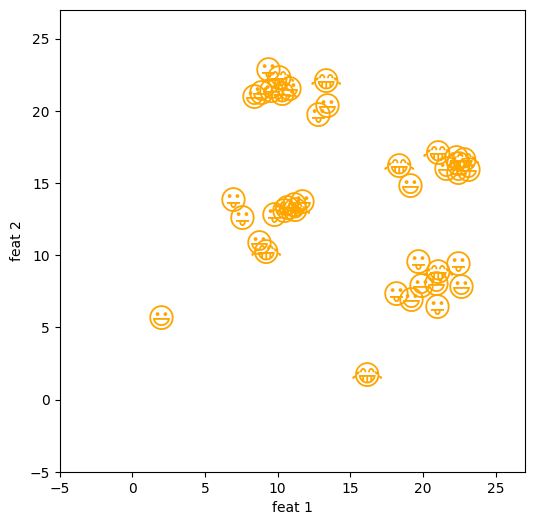

In [7]:
# @markdown Secvența de cod ce generează date și le reprezintă grafic
# Generate syntetic data.
student_feats = generate_data(n_samples=40, n_feats=2)

# Plots the observed data.
# Value for feature 1 (age) is represented on x-axis.
# Value for feature 2 (personality) is represented on y-axis.
plot_data(student_feats)

# Distanța dintre puncte

Să ne amintim că procesul de clusterizare presupune gruparea datelor în clustere în funcție de similaritare. Prin urmare este important să definim similaritatea și să cuantificăm gradul de similaritate, urmând să aplicăm apoi un algoritm de grupare.

Pentru a măsura similaritatea dintre două puncte putem folosi orice distanță , cele mai utilizate distanțe fiind:

- distanța euclidiană
- distanța cosinus

Pentru a alege formula de distanță potrivită ar trebui să ne gândim la ce înseamnă ca două observații să fie similare: distanța (😂, 😃) =?
Sau ce înseamnă ca doi oameni să aibă preferințe muzicale similare?
Când două stele ar trebui considerate ca făcând parte din aceeași galaxie sau dacă două puncte aparțin aceluiași obiect?

Această alegere este subiectivă, insa alegerea unei distanțe adecvate poate influența foarte mult rezultatele.

Considerăm punctele

- ${x_i}$ de coordonatele $x_{i_1}$ și $x_{i_2}$
- ${x_j}$ de coordonatele $x_{j_1}$ și $x_{j_2}$

și definim:

**Distanța euclidiană dintre punctele ${x_i}$ și ${x_j}$:**

$\color{blue}{dist(x_i,x_j) = \sqrt{\sum_{k=1}^{2}(x_{i_k}-x_{j_k})^2)}}$

<=>

$\color{blue}{dist(x_i,x_j) = \sqrt{(x_{i_1}-x_{j_1})^2+(x_{i_2}-x_{j_2})^2}}$

**Distanța cosinus dintre punctele ${x_i}$ și ${x_j}$, ${\phi}$ fiind unghiul dintre cei 2 vectori:**

$\color{green}{dist(x_i,x_j) = 1-cos(\phi) =1- \frac{x_i^T x_j}{\sqrt{(x_i^Tx_i)}\sqrt{x_j^Tx_j}}}$

<=>

$\color{green}{dist(x_i,x_j) = 1-cos(\phi) =1- \frac{x_{i_1}{\times}x_{j_1}+x_{i_2}{\times}x_{j_2}}{\sqrt{(x_{i_1}^2+x_{i_2}^2)}{\times}\sqrt{(x_{j_1}^2+x_{j_2}^2)}}}$

Vom determina valoarea numerică a acestor distanțe pentru punctele **_bear_** ($x_1 \in \mathbb{R}^2$), **_beaver_** ($x_2 \in \mathbb{R}^2$) și **_octopus_** ($x_3 \in \mathbb{R}^2$), așa cum rezultă din imaginea alăturată


$
\begin{align}
\small
x_{beaver}&=[2, 4] \\
x_{bear}&=[3, 6] \\
x_{octopus}&=[5, 2]
\end{align}
$ <img src="https://drive.google.com/uc?export=view&id=1VPw4t3Xd1Z3q1pkEUIB4-mmWsoi5wkqa" height="250" width="300">


$
\begin{align}
&dist_{cosine}(x_{beaver}, x_{octopus})=1-\frac{2\times5+4\times2}{\sqrt{2^2+4^2}\times\sqrt{5^2+2^2}} \approx 0,253 \\
&dist_{cosine}(x_{bear}, x_{octopus}) =1-\frac{3\times5+6\times2}{\sqrt{3^2+6^2}\times\sqrt{5^2+2^2}} \approx 0,253 \\
\end{align}
$

$
\begin{align}
&dist_{euclid}(x_{beaver}, x_{octopus})=\sqrt{(5-2)^2+(2-4)^2} \approx 3.6 \\
&dist_{euclid}(x_{bear}, x_{octopus})=\sqrt{(5-3)^2+(2-6)^2}  \approx 4,47\\
\end{align}
$

Observăm că distanța euclidiană dintre octupus și beaver este mai mică decât distanța euclidiană dintre octupus și bear, în timp ce distanța cosinus dintre octupus și beaver este egală cu distanța cosinus dintre octupus și bear deoarece în cazul distanței cosinus contează doar unghiul dintre vectori, care este același în acest caz, originea, beaver și bear fiind coliniare.

De exemplu, în domeniul procesării limbajului natural, când vorbim despre text, dacă avem 3 texte, în primele două se vorbește despre școală, iar în cel de-al treilea se vorbește despre sport. Primul text este de două ori mai lung decat cel de-al doilea. Setul de cuvinte care va fi pentru noi vectorul de reprezentare al documentului este același pentru primele doua texte. Când analizăm simularitatea dintre texte, ne așteptăm ca primele două texte să aibă același grad de simularitate cu cel de-al treilea. In acest caz, lungimea textului nu ar trebui să influențeze metrica de similaritate, prin urmare este recomandată distanța cosinus.
Pe de altă parte, dacă vorbim de astronomie, aici folosim în general distanța euclidiană.

Reținem că alegerea modului de calcul a distanței influențează gradul de similaritate dintre date. De exemplu, în cazul distanței cosinus, contând doar unghiul, date care din punct de vedere al distanței euclidiene sunt foarte departe, ar putea fi similare dacă unghiul este mic.

În general poate fi greu de determinat care ar fi distanța corectă. De exemplu daca considerăm cazul imaginilor, nici distanța euclediană, nici cea cosinus nu pare a fi ideală cand imaginile sunt representate ca un tablou de pixeli. Aceste distance pot fi arbitrar de mari chiar dacă cele două imagini ar conține același obiect, daca fundalul imagini este diferit. Problema aceasta poate fi abordată in doua feluri. Fie consideram o distanța nouă care reflecta mai bine intenția noastra, sau reprezentăm imaginile in mod diferit, astfel incât distanța euclediană (sau cosinus) să reflecte similaritatea pe care o dorim între imagini. O astfel de representare, similar cu cea menționata pentru text, ar putea fi un vector, unde fiecare dimensiune reprezintă un obiect diferit, si valoarea vectorului pe o anumită dimensiune reprezintă numarul de instanțe prezente in imagine ale obiectului respectiv.

Alegerea modului de calcul al distanței dintre date si decizia cum sa fie reprezentate datele respective implică, de obicei, o anumită înțelegere a datelor în sine și poate produce o diferență semnificativă în rezultatele obținute.
**Indiferent de formula de calcul a distanței (distanța cosinus sau distanța euclidiană), cu cât distanța e mai mică (datele sunt "mai aproape") cu atât similaritatea este mai mare.**


Funcția de calcul a distanței dintre 2 puncte având ca parametri punctele și tipul distanței, implicit fiind distanța euclidiană


In [10]:
# @ Calculul distantei
def compute_distance(x, y, dist_type="euclid"):
    """Compute {dist_type} distance.
    Args:
        x (ndarray): first argument for distance function.
        y (ndarray): second argument for distance function.
        dist_type (string): the type of measure required.
    Returns:
        distance (int): computed distance.
    """

    dist = 0.0
    if dist_type == "euclid":
        for xk, yk in zip(x, y):
            dist += (xk - yk) ** 2
        return math.sqrt(dist)

    elif dist_type == "cosine":
        sim = (np.transpose(x) * y) / (
            math.sqrt(np.transpose(x) * x) * math.sqrt(np.transpose(y) * y)
        )
        return -sim
    else:
        raise ValueError("Unknown distance type: {}".format(dist_type))

#Algoritmi de clusterizare

Există mai mulți algoritmi de clusterizare și alegerea algoritmului pe care sa il folosim in fiecare situatie se face în funcție de aplicație, de memoria disponibilă și de constrângerile de timp.

În acest capitol, vom prezenta cel mai utilizat algoritm de clusterizare, _K-means_


##Algoritmul K-means

Pentru algoritmul _K-means_ trebuie să știm încă de la început **numărul de clustere**. Intuitiv, grupăm punctele în clustere, astfel încât fiecare punct să fie cât mai aproape de centrul clusterului său.

Utilizând **distanța euclidiană** pentru a stabili „apropierea” dintre puncte, algoritmul _K-means_ este următorul:

- **Pasul 1- INIȚIALIZARE** Generăm aleator K puncte pe care le considerăm a fi reprezentanții (centroizii) celor K clustere, câte unul pentru fiecare cluster. Acești centroizi sunt dispuși aleator în spațiu. Vom vedea mai târziu că este important ca acești centroizi să fie dispuși pe întreaga zonă acoperită de date.
- **Pasul 2 - ASIGNARE** Fiecare punct din setul de date va fi asociat celui mai apropiat centroid (aflat la distanță minimă). Apare astfel o grupare a datelor în clustere.
- **Pasul 3 - ACTUALIZARE** Pentru fiecare cluster obținut la pasul 2, se determină reprezentantul (centroidul) ca medie a punctelor din clusterul respectiv
- **Repetați Pasul 2 - Pasul 3**, până când centroizii nu se mai schimbă.


##Exemplu vizual, pas cu pas, pentru algoritmul K-means
Custerizarea a $11$ puncte situate în spațiul 2D în $K=3$ clustere:

**Pasul 1: Initializare.**
Am reprezentat cu gri cele 11 puncte ce urmează a fi grupate și am marcat cu un "X" centroizii, inițializați în mod aleator

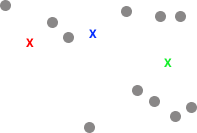

**Pasul 2: Asignare.**
Se determină, pentru fiecare punct, distanțele față de cei 3 centrozi

\\

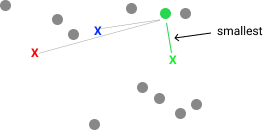

Se asociază fiecare punct element celui mai apropiat centroid, obținându-se astfel o grupare a punctelor în clustere

\\

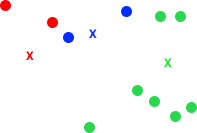

**Pasul 3: Actualizare**

Se determină media punctelor din cluster, altfel spus punctul cel mai apropiat de toate celelalte puncte din clusterul respectiv.

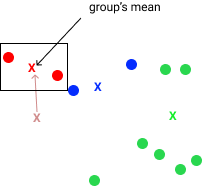

Actualizarea centroizilor pentru fiecare cluster obținut la pasul anterior

\\

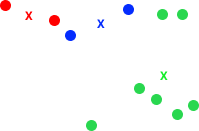


**_Notă:_** Este demonstrat matematic că după un număr finit de pași centroizi vor ramane fixați (centroizii nu se mai modifica de la o iteratie la urmatoarea), altfel spus acest algoritm converge către un minim local.

**_Obiectivul_** acestui algoritm este de a minimiza, în interiorul fiecărui cluster $C_j$, media distanțelor de la puncte la centroidul clusterului

$\frac{\sum_{x \in C_j}dist(x - u_j)}{N}$, unde N este numărul de puncte din clusterul $C_j$, iar $u_j$ este centroidul acestui cluster

Fie clusterele $C_1$,$C_2$,...$C_K$, având centroizii $u_1$,$u_2$,...$u_K$ notăm

$L = \sum_{j=1}^K \sum_{x \in C_j}dist(x - u_j)$.

O valoare mică pentru $ L $ ne arată că punctele sunt bine concentrate în jurul centroizilor. Se poate demonstra că în timpul ciclului repetitiv din algoritmul k-means, L scade. Deci, pe măsură ce avansăm, clusterizarea este îmbunătățită.


##Implementare algoritm K-means


In [11]:
# K-means algorithm
# Step 1
def random_initialize(data, n_clusters):
    idxs = np.random.choice(range(data.shape[0]), n_clusters)
    centroids = np.array([data[i] for i in idxs])
    return centroids


def custom_initialize(init_array=[]):
    centroids = init_array
    return centroids


# Step 2
def assign_clusters(data, centroids):
    """Assign each exemple to its closest centroid

    Args:
        data (ndarray): observed students.
        centroids (ndarray): current clusters' centroids.
    Returns:
        assignment (ndarray): the assignment at crt step.
    """
    n_clusters = centroids.shape[0]
    n_samples = data.shape[0]
    assignment = {}
    clusters = {}

    for i in range(n_clusters):
        clusters[i] = []

    for j in range(n_samples):
        min_dist = 100000
        min_idx = -1
        for i in range(n_clusters):
            dist_ij = compute_distance(data[j], centroids[i])
            if dist_ij < min_dist:
                min_dist = dist_ij
                min_idx = i
        assignment[j] = min_idx
        clusters[min_idx].append(data[j])

    return assignment, clusters


# Step 3
def update_centroids(clusters, n_clusters, n_feats):
    """Compute new centroids by averaging examples in each cluster.

    Args:
        clusters (list): lists containing the elements from each cluster.
        n_clusters (int): number of clusters.
        n_feats (int): number of features.
    Returns:
        centroids (ndarray): the updated centroids.
    """

    centroids = np.zeros((n_clusters, n_feats))
    for i in range(n_clusters):
        centroids[i] = np.mean(clusters[i], axis=0)
    return centroids


def kmeans(data, k, init_policy="random", init_centroids=None, voronoi=False):
    n_feats = data.shape[1]
    assignment = {}
    frames = []

    # Step 1
    if init_policy == "random":
        centroids = random_initialize(data, n_clusters=k)
    else:
        centroids = custom_initialize(init_centroids)

    # Step 2
    assignment, clusters = assign_clusters(data, centroids)
    while True:
        old_assignment = assignment
        # Step 3
        centroids = update_centroids(clusters, k, n_feats)
        # Step 2
        assignment, clusters = assign_clusters(data, centroids)
        frames.append(plot_clusters(data, assignment, centroids, voronoi=voronoi))
        # finish when the algorithm reachs a fixed point
        if old_assignment == assignment:
            break
    # print(f"iterations: {len(frames)}, clusters: {centroids.shape[0]}")
    return frames, centroids, assignment

##Execuție algoritm K-means


In [14]:
# Run this code to apply k-means on data
np.random.seed(121)
frames, centroids, assignment = kmeans(student_feats, k=4, voronoi=True)


def plot_clusters_refresh(iter):
    ipyplot.plot_images([frames[iter]], [f"Iteration: {iter}"], img_width=300)


_ = widgets.interact(plot_clusters_refresh, iter=(0, len(frames) - 1, 1))

interactive(children=(IntSlider(value=1, description='iter', max=3), Output()), _dom_classes=('widget-interact…

Deci, așa cum era de așteptat, observăm că punctele mai apropiate aparțin aceluiași cluster și atribuirea este îmbunătățită la fiecare iterație.

Practic, am împărțit persoanele în 4 grupuri, fiecare având caracteristici similare. În cazul nostru, datorită caracteristicilor selectate, acestea vor avea vârste similare și un tip de personalitate similar.

Ar trebui reținut că, prin construcție, algoritmul K-means împarte spațiul în regiuni convexe (descrise în culori) astfel încât fiecare regiune să corespundă unui grup. O regiune este desenată astfel încât toate punctele din interiorul regiunii să fie mai aproape de centroidul regiunii (marcat cu un semn „x”) decât de orice alt centroid disponibil. Astfel, ne așteptăm ca o nouă persoană situată în regiunile „roșii” să aibă similarități cu alte persoane din aceleași regiuni.

Mai mult, pentru fiecare cluster, algoritmul produce un centroid. Intuitiv, acest lucru ar putea fi văzut ca un „prototip”: un exemplu reprezentativ pentru grupul respectiv.


Uneori modul în care datele sunt grupate în urma aplicării algoritmului K-means nu este cel așteptat și acest lucru poate fi cauzat de:

- un număr nepotrivit de clustere
- o inițializare irelevantă a centroizilor


##Numărul de clustere

Pentru a rula algoritmul K-means, trebuie să furnizăm numărul de clustere K. Algoritmul k-means nu oferă nicio intuiție despre care este cea mai bună alegere pentru acest parametru.

Nu știm care este cea mai bună alegere a numărului de clustere, dar știm că numărul de clustere influențează rezultatele aplicării alogormului K-means.
Cu prea puține clustere, putem forța ca date nesimilare (care aparțin unor grupuri distincte) să se grupeze într-un cluster mare, în timp ce având prea multe clustere algoritmul va diferenția artificial entități similare.

De exemplu, dacă suntem interesați să împărțim clasa în 4 echipe pentru un joc, alegerea lui K este evidentă. Dar, dacă, în schimb, ne interesează câte categorii de elevi avem, algoritmul K-means standard nu ne poate oferi un răspuns direct.

**Analiza vizuală a influenței numărului de clustere asupra grupării datelor: **



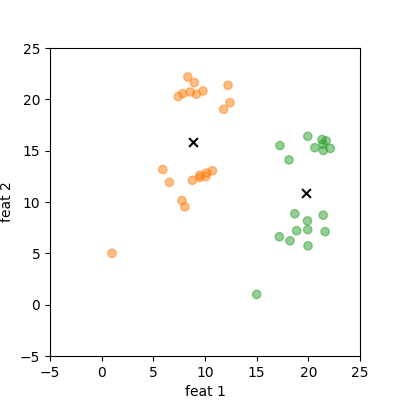
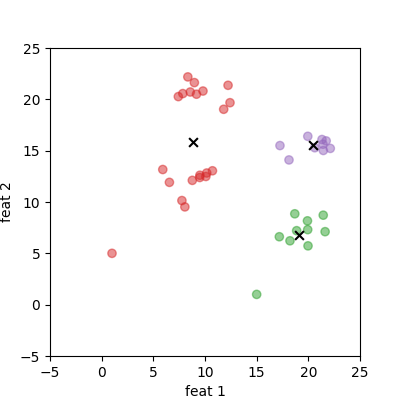
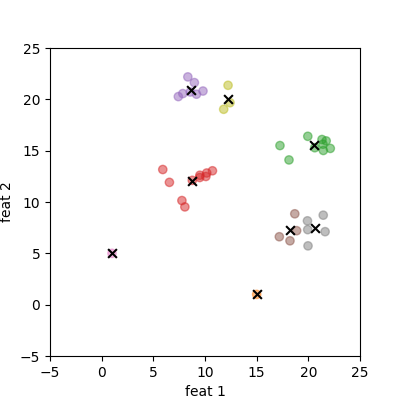


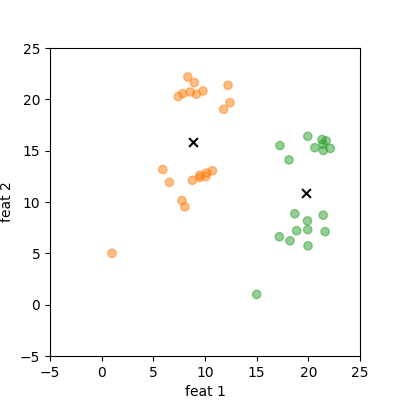
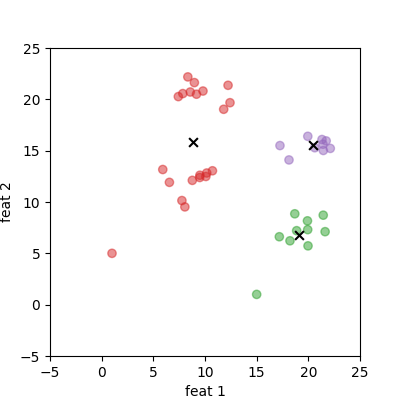
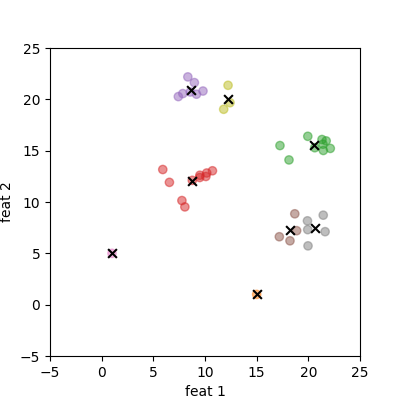

In [15]:
# Analyse how the number of clusters k influence the clusterization
np.random.seed(224)

final_states = []
ks = [2, 4, 8]  # you can play with the number of clusters by replacing these values
for k in ks:
    frames_no, centroids_no, assignment_no = kmeans(
        student_feats, k=k, init_policy="random"
    )
    final_states.append(frames_no[-1])

plot_final_states(final_states, ks)

##Inițializarea centroizilor

Exemple de inițializare irelevantă, chiar "nefericită" am putea spune, a centrozilor:

- cei K centroizi generați aleator coincid sau o parte dintre centroizi coincid ceea ce va conduce la un număr mai mic de clustere (numărul de centroizi diferiti), în cazul în care toți coincid vom avea un singur cluster
- cei K centroizi generați aleator nu acoperă relevant zona datelor. Dacă avem centroizi la distanță mică unul de celălalt (comparativ cu distantele la care se află datele), clusterele pe care le reprezintă se vor unifica după mai multe iterații

Initializărea centrozilor influențează și rapiditatea cu care converge algoritmul K-means. Altfel spus, o inițializare bună înseamnă mai puține iterații ale algoritmului, prin urmare o eficiență ca timp mai bună.

Analiza vizuală a influenței inițializării centroizilor asupra grupării datelor:



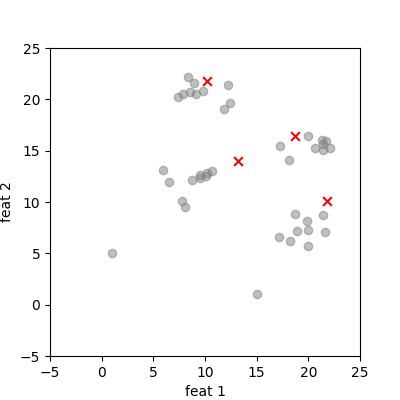
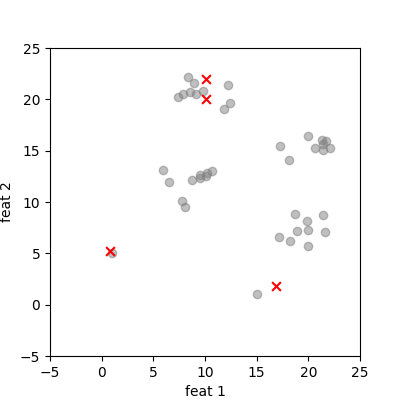


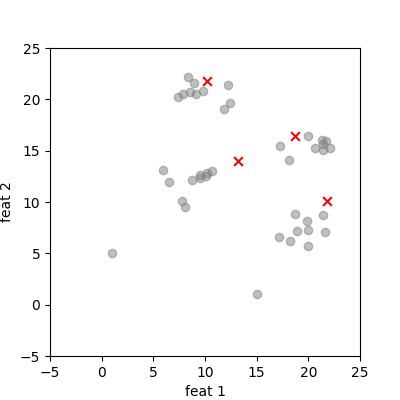
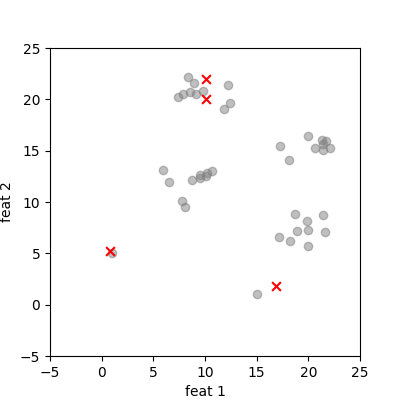


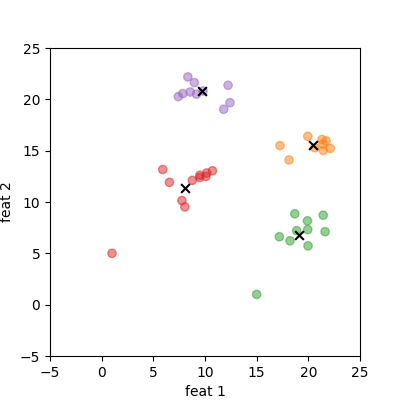
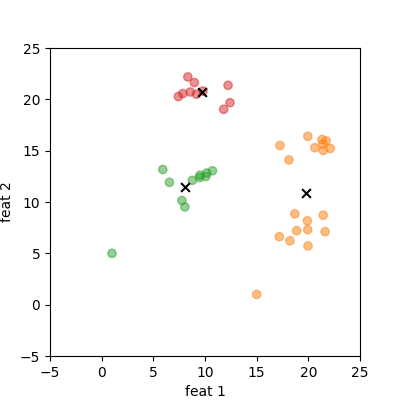


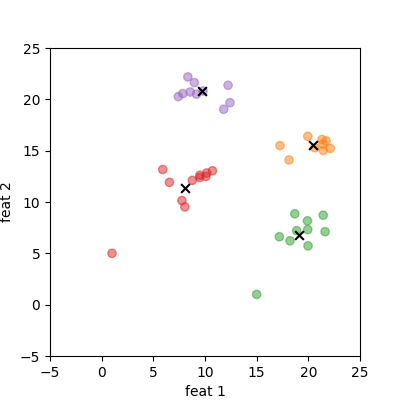
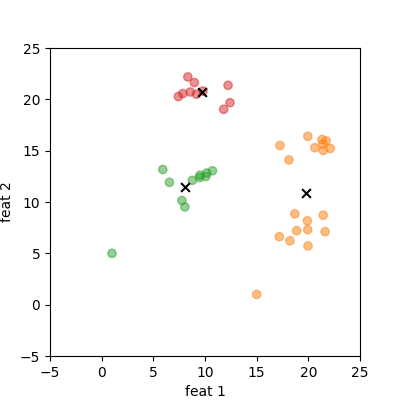

In [18]:
# Analyse the impact of the initialization for the final clustering configuration.
# When we initilize two centroid too close to each other, their clusters will collaps.
# (it should be 4 clusters but two of them contains the same elements)

init_centroids_good = np.array([[17.3, 15.5], [20, 8.7], [12.5, 13.4], [8.6, 20.3]])
frames_good, centroids_good, assignment_good = kmeans(
    student_feats, k=4, init_policy="custom", init_centroids=init_centroids_good
)

# init_centroids_bad = np.array([[0, -15], [-15, -10], [-5, 5], [-5.00001, 5]])
# frames_bad, centroids_bad, assignment_bad = kmeans(student_feats,k=4,
#           init_policy='custom', init_centroids=init_centroids_bad)
init_centroids_bad = np.array([[15, 0], [0, 5], [10, 20], [10.0000000000000001, 20]])
frames_bad, centroids_bad, assignment_bad = kmeans(
    student_feats, k=4, init_policy="custom", init_centroids=init_centroids_bad
)

frames_init_good = plot_centroids(student_feats, init_centroids_good)
frames_init_bad = plot_centroids(student_feats, init_centroids_bad)

plot_final_states(
    [frames_init_good, frames_init_bad],
    ["step_initial_good_init", "step_initial_bad_init"],
)
plot_final_states(
    [frames_good[-1], frames_bad[-1]], ["step_final_good_init", "step_final_bad_init"]
)

Referitor la inițializarea centroizilor, in practica se pot folosi diferite metode pentru a evita probleme mentionate mai sus:

- soluții inteligente/informate de a distribui centroizii bazate pe analizarea regiunii datelor
- rularea algortmului de mai multe ori cu inițializări aleatoare diferite și alegerea celei mai bune soluții


##Setul de date

Sunt situații în care chiar și pentru o alegere potrivită a numărului de clustere și o inițializare relevantă a centroizilor, gruparea datelor în clustere prin aplicarea algoritmului K-means nu este cea așteptată.

Unul dintre obiectivele algoritmului K-means este acela de a partiționa spațiul datelor în zone convexe.

Ne reamintim că o regiune este convexă dacă și numai dacă orice punct de pe segmentul care unește două puncte din regiunea menționată face parte, de asemenea, din regiune. Convexitatea are implicații, atât algebrice, cât și geometrice.
<img src="https://drive.google.com/uc?export=view&id=1waejnRUcbl1EbBzhK6iOrPCIudY3l38X" height="200">

Algoritmul K-means va împărți întotdeauna spațiul în regiuni convexe, fiecare regiune corespunzând unui cluster. Prin urmare, dacă partiționarea reală a datelor corespunde unor regiuni care nu sunt convexe, algoritmul K-means nu le va putea identifica. În schimb, va găsi cea mai apropiată descompunere a spațiului în regiuni convexe.


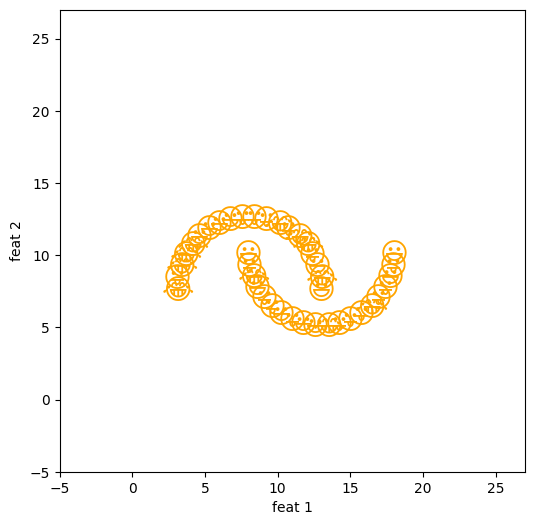

In [19]:
# Execute this cell to generate some non-convex data and then plot it.
# Generate syntetic data.
nonconvex_feats = generate_nonconvex_data(n_samples=40, n_feats=2)
plot_data(nonconvex_feats)

Pentru un astfel de set de date, indiferent de modul de inițializare a centroizilor, pentru $ k = 2 $ (numărul potrivit de clustere) gruparea realizată prin algoritmul K-means este diferită de cea naturală.



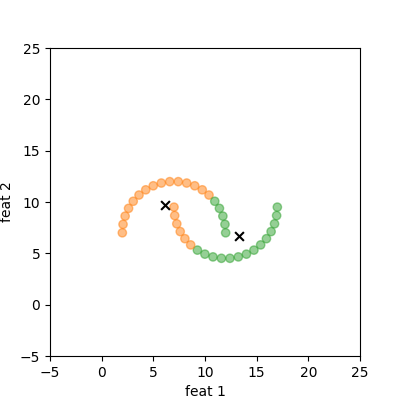


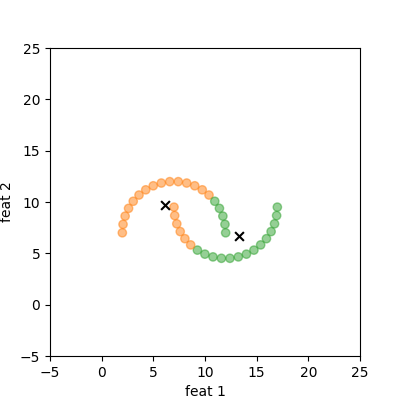

In [23]:
frames, centroids, assignment = kmeans(nonconvex_feats, k=2, init_policy="random")
plot_final_states([frames[-1]], ["non-convex"])

#Concluzii
❗️**_Pro K-means:_**

- converge rapid în practică
- aplicabil pe scară largă
- ușor de implementat

❗️**_Contra K-means:_**

- sensibil la inițializarea centrozilor
- numărul de clustere este predefinit
- funcționează prost pe date neconvexe
- sensibil la valori aberante

Clusterizarea ierarhică este o abordare alternativă la K-means, care nu necesită specificarea numărului de clustere. Ea realizează acest lucru producând o ierarhie de clustere, în loc de una singură. Vă puteți imagina acest lucru gândindu-vă la modul în care lumea noastră este organizată geografic:

- mai multe case sunt grupate în localități
- mai multe localități formează un județ
- mai multe județe formează o țară
- mai multe țări formează un continent

În funcție de cât de adânc intrăm în această ierarhie, avem o grupare diferită cu un număr diferit de clustere.
Algoritmii care implementează o clusterizare ierarhică (**_Divisive clustering_** și **_Agglomerative clustering_**) au o complexitate mai mare ca timp de execuție și memorie alocată
